In [122]:
from functools import partial

from ariel_experiments.characterize.canonical.core.toolkit import (
    CanonicalToolKit as ctk,
)
from ariel_experiments.characterize.individual import analyze_neighbourhood
from ariel_experiments.utils.initialize import (
    generate_random_population_parallel,
)


from ariel_experiments.characterize.individual import analyze_canonical_string
from ariel_experiments.characterize.population import (
    derive_matrix_numerics,
    matrix_derive_neighbourhood,
    get_full_analyzed_population,
)
from ariel_experiments.gui_vis.gui import (
    IndividualVisualizer,
)
from ariel_experiments.gui_vis.gui_simple import (
    SimpleNavigator,
)

from ariel_experiments.gui_vis.visualize_tree import visualize_tree_from_graph

import seaborn as sns
import numpy as np
import plotly.graph_objects as go

from ariel_experiments.gui_vis.view_mujoco import view

import matplotlib.pyplot as plt

In [123]:
from rich.console import Console
console = Console()

In [124]:
def plot_matrix_distribution(
    matrix: np.ndarray,
    triangle: str = "upper",
    include_diagonal: bool = False,
    cmap: str = "viridis",
    bins: int = 190,
    figsize: tuple[int, int] = (14, 6),
    title_prefix: str = ""
):
    """Plot matrix heatmap and value distribution side by side."""
    
    # Extract triangle values
    k_offset = 1 if not include_diagonal else 0
    
    if triangle.lower() == "upper":
        values = matrix[np.triu_indices_from(matrix, k=k_offset)]
        mask = np.tril(np.ones_like(matrix, dtype=bool), k=k_offset-1)
        triangle_name = "Upper"
    elif triangle.lower() == "lower":
        values = matrix[np.tril_indices_from(matrix, k=-k_offset)]
        mask = np.triu(np.ones_like(matrix, dtype=bool), k=-k_offset+1)
        triangle_name = "Lower"
    else:
        raise ValueError("triangle must be 'upper' or 'lower'")
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot heatmap
    sns.heatmap(
        matrix,
        mask=mask,
        ax=axes[0],
        cmap=cmap,
        square=True,
        cbar_kws={'label': 'Value'}
    )
    diag_text = "with" if include_diagonal else "without"
    axes[0].set_title(f'{title_prefix}{triangle_name} Triangle Heatmap\n({diag_text} diagonal)')
    axes[1].hist(values, bins=bins, alpha=0.7, edgecolor='black', color='steelblue')
    axes[1].axvline(np.mean(values), color='black', linestyle='--', 
                    linewidth=1, label=f'Mean: {np.mean(values):.3f}')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{title_prefix}Value Distribution (n={len(values)})')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Add statistics text
    stats_text = (
        f'Min: {np.min(values):.3f}\n'
        f'Max: {np.max(values):.3f}\n'
        f'Std: {np.std(values):.3f}'
    )
    axes[1].text(0.98, 0.97, stats_text,
                transform=axes[1].transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                fontsize=9)
    
    plt.tight_layout()
    return fig, axes


In [125]:
population_size = 1000

In [126]:
population = generate_random_population_parallel(population_size)

Output()

In [ ]:
radius_strategy = ctk.RadiusStrategy.TREE_GLOBAL
max_tree_radius = 3

missing_data_mode = ctk.MissingDataMode.SKIP_RADIUS

tanimoto_mode = ctk.TanimotoMode.COUNTS
weighting_mode = ctk.WeightingMode.LINEAR


softmax_beta = 1
power_mean_p = 2


similarity_config = ctk.SimilarityConfig(
    radius_strategy=radius_strategy,
    weighting_mode=weighting_mode,
    max_tree_radius=max_tree_radius,
    missing_data_mode=missing_data_mode,
    tanimoto_mode=tanimoto_mode,
    softmax_beta=softmax_beta,
    power_mean_p=power_mean_p,
)

In [128]:
analyzed_population = get_full_analyzed_population(
    population,
    analyzers=[
        partial(analyze_neighbourhood, config=similarity_config),
    ],
    derivers=[],
    n_jobs=-1, # fastest
)
matrix_result = matrix_derive_neighbourhood(
    analyzed_population.raw,
    config=similarity_config,
    symmetric=True,
    n_jobs=-1 # fastest
)

analyzed_population.derived["neighbourhood"]["similarity_matrix"] = matrix_result["similarity_matrix"]

Output()

Output()

Computing neighbourhood:   0%|          | 0/100 [00:00<?, ?batch/s]

In [129]:
analyzed_population.show_tree()

AnalyzedPopulation — props=1 derived_keys=1
├── raw
│   └── neighbourhood: len=1000, type=dict
└── derived
    └── neighbourhood
        └── similarity_matrix

In [130]:
matrix = analyzed_population.derived["neighbourhood"]["similarity_matrix"]['full']
upper_triu_idx = np.triu_indices_from(matrix, k=1)
vals = matrix[upper_triu_idx]

-----

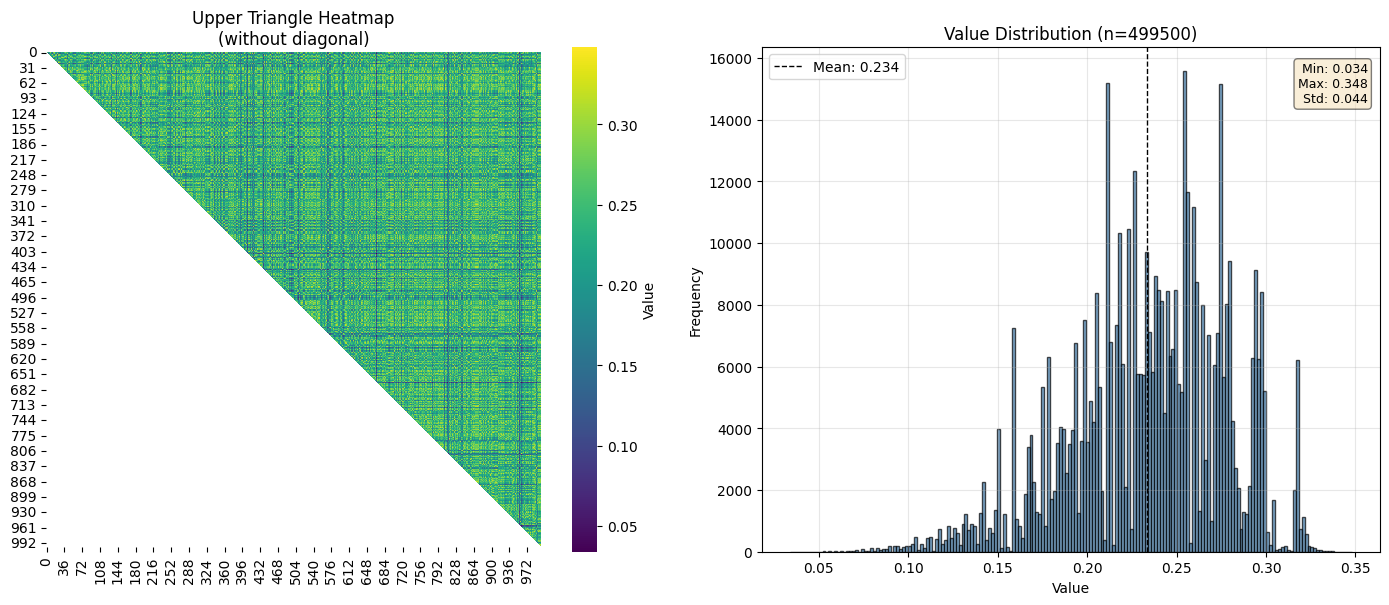

In [131]:
fig, axes = plot_matrix_distribution(matrix)
plt.show()

##### Highest similarity

In [132]:
N = 20
if vals.size == 0:
    top = []
else:
    k = min(N, vals.size)
    sel = np.argpartition(-vals, k-1)[:k]               # top k (unsorted)
    sel = sel[np.argsort(-vals[sel])]                   # sorted desc
    rows = upper_triu_idx[0][sel]
    cols = upper_triu_idx[1][sel]
    top = list(zip(rows.tolist(), cols.tolist(), vals[sel].tolist()))

# top is a list of (row, col, value) tuples sorted by value desc
console.print(top)

iterator = 0

[
    (469, 803, 0.3479999899864197),
    (277, 884, 0.34700000286102295),
    (353, 522, 0.34700000286102295),
    (180, 876, 0.3449999988079071),
    (688, 836, 0.3440000116825104),
    (183, 465, 0.34200000762939453),
    (117, 571, 0.3400000035762787),
    (294, 967, 0.3400000035762787),
    (431, 567, 0.33799999952316284),
    (214, 930, 0.33799999952316284),
    (172, 549, 0.33799999952316284),
    (510, 607, 0.33799999952316284),
    (114, 727, 0.33799999952316284),
    (834, 962, 0.33799999952316284),
    (148, 928, 0.3370000123977661),
    (32, 803, 0.3370000123977661),
    (292, 383, 0.3370000123977661),
    (102, 246, 0.3370000123977661),
    (297, 611, 0.3370000123977661),
    (389, 506, 0.3370000123977661)
]

keep pressing this notebook cell to iterate over the robots

viewing: 469 with similarity [0.3479999899864197]

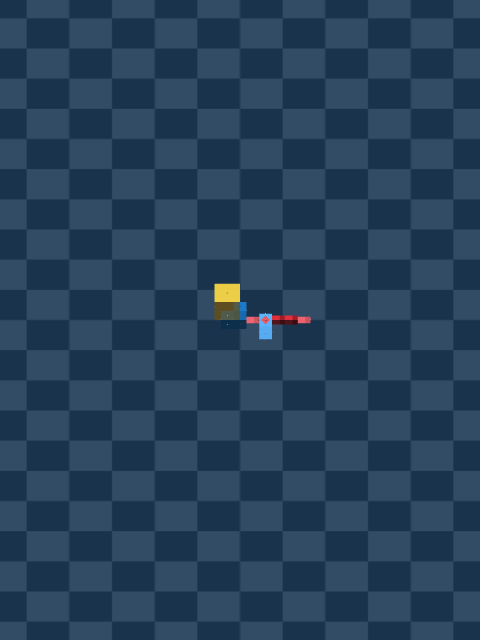

viewing: 803 with similarity [0.3479999899864197]

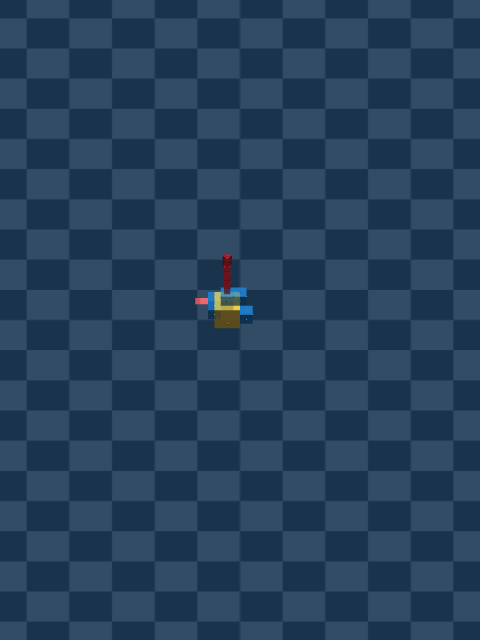

SimilarityResults(
    neighbourhood_dicts=(
        {
            0: ['C', 'B', 'B', 'H', 'B', 'H', 'H', 'H', 'B', 'H', 'H', 'B', 'B'],
            1: [
                'C[r(B)]',
                'C[r(B[l(B)])]',
                'B[l(B[l(B)]H3)]',
                'BH3B',
                'HB[lt(B)]H3',
                'BH3H2',
                'HH2H3',
                'HH3',
                'B[l(BH1)]',
                'BH1H2',
                'HH2',
                'B[r(B)]',
                'B[l(B)]'
            ],
            2: [
                'C[r(B[l(B)])]',
                'C[r(B[l(B[l(B)]H3)])]',
                'C[r(B[l(B[l(B)]H3B)])]',
                'B[l(B[l(B)]H3B[lt(B)]H3)]',
                'BH3B[t(B)l(BH1)]H3H2',
                'HB[lt(B)]H3H2H3',
                'BH3H2H3',
                'HH2H3',
                'HB[t(B)l(BH1H2)]H3',
                'B[l(BH1H2)]',
                'BH1H2',
                'HB[lt(B)]H3',
                'B[l(B[l(B)]H3)]'
            ],
            3: [
                'C[r(B[l(B[l(B)]H3)])]',
                'C[r(B[l(B[l(B)]H3B)])]',
                'C[r(B[l(B[l(B)]H3B[lt(B)]H3)])]',
                'C[r(B[l(B[l(B)]H3B[t(B)l(BH1)]H3H2)])]',
                'B[l(B[l(B)]H3B[t(B)l(BH1H2)]H3H2H3)]',
                'BH3B[t(B)l(BH1)]H3H2H3',
                'HB[lt(B)]H3H2H3',
                'BH3H2H3',
                'BH3B[t(B)l(BH1H2)]H3H2',
                'HB[t(B)l(BH1H2)]H3',
                'B[l(BH1H2)]',
                'BH3B[t(B)l(BH1)]H3H2',
                'C[r(B[l(B[l(B)]H3B)])]'
            ]
        },
        {
            0: ['C', 'B', 'H', 'H', 'H', 'H', 'B', 'B', 'B', 'H', 'B', 'B'],
            1: [
                'C[fl(B)]<t(B)>',
                'C<t(B[r(B)]H)>',
                'BH2H2',
                'HH2H2',
                'HH2H3',
                'HH3',
                'B[r(B)]',
                'C[r(B[l(B)])]',
                'B[l(B[l(B)]H3)]',
                'BH3',
                'B[l(B)]',
                'C[r(B)]'
            ],
            2: [
                'C[l(B)b(B[l(B)])]<t(B[r(B)]H)>',
                'C[bl(B)]<t(B[r(B)]HH2)>',
                'C<t(B[t(B)]H2H2H2)>',
                'BH2H2H2H3',
                'HH2H2H3',
                'HH2H3',
                'C<t(B[t(B)]H2)>',
                'C[b(B)r(B[l(B[l(B)]H3)])]<t(B)>',
                'C[r(B[l(B[l(B)]H3)])]',
                'B[l(B[l(B)]H3)]',
                'B[l(B[l(B)]H3)]',
                'C[bl(B)]<t(B)>'
            ],
            3: [
                'C[b(B)r(B[l(B[l(B)]H3)])]<t(B[t(B)]H2H2)>',
                'C[b(B)r(B[l(B)])]<t(B[t(B)]H2H2H2)>',
                'C[br(B)]<t(B[t(B)]H2H2H2H3)>',
                'C<t(B[t(B)]H2H2H2H3)>',
                'BH2H2H2H3',
                'HH2H2H3',
                'C[br(B)]<t(B[t(B)]H2H2)>',
                'C[b(B)r(B[l(B[l(B)]H3)])]<t(B[t(B)]H2)>',
                'C[b(B)r(B[l(B[l(B)]H3)])]<t(B)>',
                'C[r(B[l(B[l(B)]H3)])]',
                'C[r(B[l(B[l(B)]H3)])]',
                'C[b(B)r(B[l(B)])]<t(B[t(B)]H2)>'
            ]
        }
    ),
    similarity_value=0.3488939251593549,
    tanimoto_dict={0: 0.9230769230769231, 1: 0.3888888888888889, 2: 0.13636363636363635, 3: 0.041666666666666664},
    selected_radii=[0, 1, 2, 3],
    obtained_weights=[1.0, 2.0, 3.0, 4.0]
)

In [133]:
node1 = ctk.from_graph(population[top[int(0 + iterator)][0]]).canonicalize()
node2 = ctk.from_graph(population[top[int(0 + iterator)][1]]).canonicalize()

console.print(f"viewing: {top[int(iterator)][0]} with similarity {[top[int(iterator)][2]]}")
view(node1.to_graph())
console.print(f"viewing: {top[int(iterator)][1]} with similarity {[top[int(iterator)][2]]}")
view(node2.to_graph())

results = ctk.calculate_similarity(node1, node2, config=similarity_config, return_all=True)
console.print(results)

iterator += 1 % N

##### Lowest similarity

In [134]:
N = 20

if vals.size == 0:
    bottom = []
else:
    k = min(N, vals.size)
    sel = np.argpartition(vals, k-1)[:k]                # bottom k (unsorted)
    sel = sel[np.argsort(vals[sel])]                    # sorted asc
    rows = upper_triu_idx[0][sel]
    cols = upper_triu_idx[1][sel]
    bottom = list(zip(rows.tolist(), cols.tolist(), vals[sel].tolist()))

# bottom is a list of (row, col, value) tuples sorted by value asc (lowest first)
console.print(bottom)
iterator = 0

[
    (439, 667, 0.03400000184774399),
    (406, 667, 0.03400000184774399),
    (439, 956, 0.03799999877810478),
    (406, 956, 0.03799999877810478),
    (406, 883, 0.03999999910593033),
    (439, 883, 0.03999999910593033),
    (439, 814, 0.0430000014603138),
    (406, 814, 0.0430000014603138),
    (667, 986, 0.04399999976158142),
    (667, 684, 0.04500000178813934),
    (509, 667, 0.04500000178813934),
    (667, 811, 0.04699999839067459),
    (667, 960, 0.04699999839067459),
    (22, 667, 0.04899999871850014),
    (667, 806, 0.04899999871850014),
    (956, 986, 0.04899999871850014),
    (190, 667, 0.04899999871850014),
    (883, 986, 0.050999999046325684),
    (509, 956, 0.050999999046325684),
    (684, 956, 0.050999999046325684)
]

viewing: 439 with similarity [0.03400000184774399]

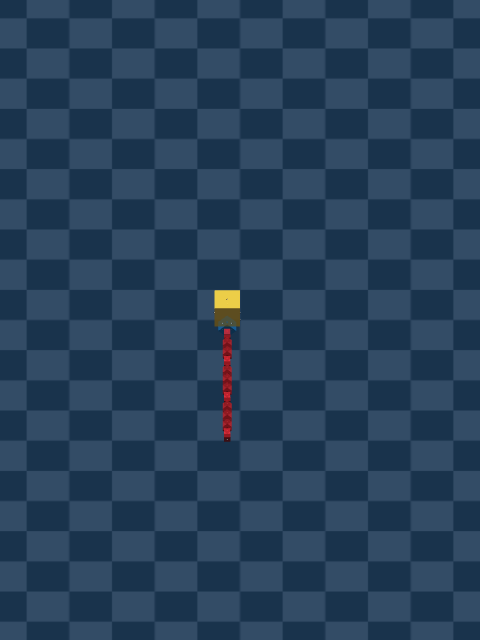

viewing: 667 with similarity [0.03400000184774399]

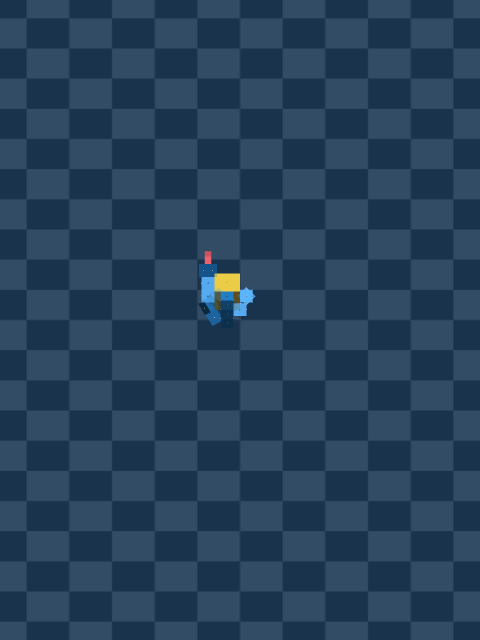

SimilarityResults(
    neighbourhood_dicts=(
        {
            0: ['C', 'B', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
            1: [
                'C[r(B1)]',
                'C[r(B1H3)]',
                'BH3H1',
                'HH1H',
                'HHH1',
                'HH1H1',
                'HH1H',
                'HHH2',
                'HH2H3',
                'HH3H3',
                'HH3H',
                'HHH2',
                'HH2H1',
                'HH1'
            ],
            2: [
                'C[r(B1H3)]',
                'C[r(B1H3H1)]',
                'C[r(B1H3H1H)]',
                'BH3H1HH1',
                'HH1HH1H1',
                'HHH1H1H',
                'HH1H1HH2',
                'HH1HH2H3',
                'HHH2H3H3',
                'HH2H3H3H',
                'HH3H3HH2',
                'HH3HH2H1',
                'HHH2H1',
                'HH2H1'
            ],
            3: [
                'C[r(B1H3H1)]',
                'C[r(B1H3H1H)]',
                'C[r(B1H3H1HH1)]',
                'C[r(B1H3H1HH1H1)]',
                'BH3H1HH1H1H',
                'HH1HH1H1HH2',
                'HHH1H1HH2H3',
                'HH1H1HH2H3H3',
                'HH1HH2H3H3H',
                'HHH2H3H3HH2',
                'HH2H3H3HH2H1',
                'HH3H3HH2H1',
                'HH3HH2H1',
                'HHH2H1'
            ]
        },
        {
            0: ['C', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'H'],
            1: [
                'C[b(B)rl(B1)]<b(B1)>',
                'C<b(B1[t(B)])>',
                'B[l(B[b(B1)])]',
                'B[r(B1[t(B1)])]',
                'B[r(B1)]',
                'C[r(B1[b(B1)])]',
                'B[r(B1)]',
                'C[r(B[tb(B)])]',
                'B[r(B)]',
                'B[t(B[b(B)])]',
                'B[l(B[r(B)t(B1)])]',
                'B[l(B)]',
                'B[r(B1)]',
                'C[r(B1[t(B)])]',
                'B[r(BB1)]',
                'BB1H3',
                'BH3'
            ],
            2: [
                'C[f(B1[b(B1)])b(B1[t(B)])r(B[tb(B)])]<b(B1[t(B)])>',
                'C[r(B)fb(B1)]<b(B1[t(B[l(B1)])])>',
                'C<b(B1[l(B[b(B1[l(B1)])])])>',
                'B[r(B[t(B1[l(B1)])])]',
                'B[r(B1[t(B1)])]',
                'C[f(B)r(B1)l(B1[b(B1)])]<b(B1)>',
                'C[r(B1[b(B1)])]',
                'C[fb(B1)r(B[b(B)t(B[b(B)])])]<b(B1)>',
                'C[r(B[tb(B)])]',
                'C[r(B[b(B)t(B[b(B[b(B)r(B1)])])])]',
                'B[r(B[l(B[r(B)t(B1)])])]',
                'B[l(B[r(B)t(B1)])]',
                'B[l(B[r(B)t(B1)])]',
                'C[f(B)l(B1)r(B1[t(BB1)])]<b(B1)>',
                'C[r(B1[t(BB1H1)])]',
                'B[r(BB1H3)]',
                'BB1H3'
            ],
            3: [
                'C[f(B1[b(B1)])b(B1[t(BB1)])r(B[b(B)t(B[b(B)])])]<b(B1[t(B[l(B1)])])>',
                'C[f(B1[b(B1)])b(B1[t(B)])r(B[tb(B)])]<b(B1[t(B[l(B1[b(B1)])])])>',
                'C[f(B)rl(B1)]<b(B1[l(B[b(B1[l(B1)])])])>',
                'C<b(B1[b(B[l(B1[b(B1)])])])>',
                'B[r(B[t(B1[l(B1)])])]',
                'C[f(B1[b(B1)])b(B1[t(B)])r(B[tb(B)])]<b(B1[t(B)])>',
                'C[f(B)r(B1)l(B1[b(B1)])]<b(B1)>',
                'C[f(B1[b(B1)])b(B1[t(B)])r(B[b(B)t(B[b(B[b(B)r(B1)])])])]<b(B1[t(B)])>',
                'C[fb(B1)r(B[b(B)t(B[b(B)])])]<b(B1)>',
                'C[fb(B1)r(B[b(B)t(B[b(B[b(B)r(B1)])])])]<b(B1)>',
                'C[r(B[b(B)t(B[b(B[b(B)r(B1)])])])]',
                'B[r(B[l(B[r(B)t(B1)])])]',
                'B[r(B[l(B[r(B)t(B1)])])]',
                'C[r(B1[b(B1)])l(B1[t(BB1H1)])b(B[tb(B)])]<b(B1[r(B)])>',
                'C[b(B)r(B1)l(B1[t(BB1H1)])

In [135]:
node1 = ctk.from_graph(population[bottom[int(iterator)][0]]).canonicalize()
node2 = ctk.from_graph(population[bottom[int(iterator)][1]]).canonicalize()

console.print(f"viewing: {bottom[int(iterator)][0]} with similarity {[bottom[int(iterator)][2]]}")
view(node1.to_graph())
console.print(f"viewing: {bottom[int(iterator)][1]} with similarity {[bottom[int(iterator)][2]]}")
view(node2.to_graph())

results = ctk.calculate_similarity(node1, node2, config=similarity_config, return_all=True)
console.print(results)

iterator += 1 % N

-----

##### Interactive heatmap

In [136]:
fig = go.Figure(data=go.Heatmap(
    z=matrix,
    colorscale='Viridis',
    hovertemplate='Row: %{y}<br>Col: %{x}<br>Value: %{z:.3f}<extra></extra>'
))

fig.update_layout(
    title='Interactive Heatmap',
    xaxis_title='Column',
    yaxis_title='Row'
)
fig.show()


-----

##### Derived stats

In [137]:
matrix_stats = derive_matrix_numerics(
    analyzed_population.derived,
    key="neighbourhood"
)
analyzed_population.derived["neighbourhood"].update(matrix_stats)

-----

##### Gui for just data

In [138]:
simple_navigator = SimpleNavigator(analyzed_population.to_dict())

----

##### Watch Robots

In [139]:
individual_visualizer = IndividualVisualizer(index_dict=analyzed_population.derived, population=population)

-----

##### See graphs

In [140]:
individual_visualizer = IndividualVisualizer(index_dict=analyzed_population.derived, population=population, visualize_fn=visualize_tree_from_graph)